In [1]:
from lib_fetaure_analysis import Features
from defect_analysis import Test
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import torch as Torch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

## Produzione contonri, calcolo features e creazione dataframe da cartella di immagini "threashed"

Newname: 
graphene_257479
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_257479.xyz
Numero atomi:
318
Newname: 
graphene_312780
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_312780.xyz
Numero atomi:
388
Newname: 
graphene_226047
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_226047.xyz
Numero atomi:
439
Newname: 
graphene_229365
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_229365.xyz
Numero atomi:
278
Newname: 
graphene_221101
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_221101.xyz
Numero atomi:
416
Newname: 
graphene_170081
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_170081.xyz
Numero atomi:
429
Newname: 
graphene_65954
Path file .xyz: 
/home/gabro/GrapheDetectProject/data.xyz/subset_xyz/graphene_65954.xyz
Numero atomi:
349
Newname: 
graphene_54884
Path file .xyz: 
/home/gabro/GrapheDetectProje

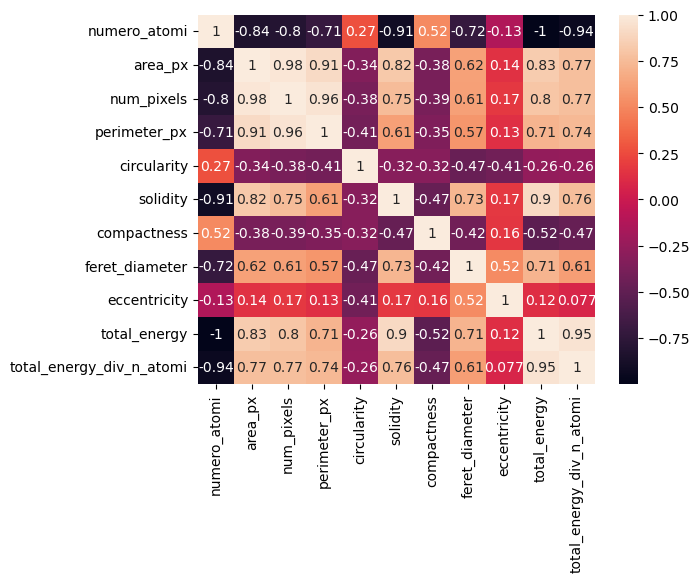

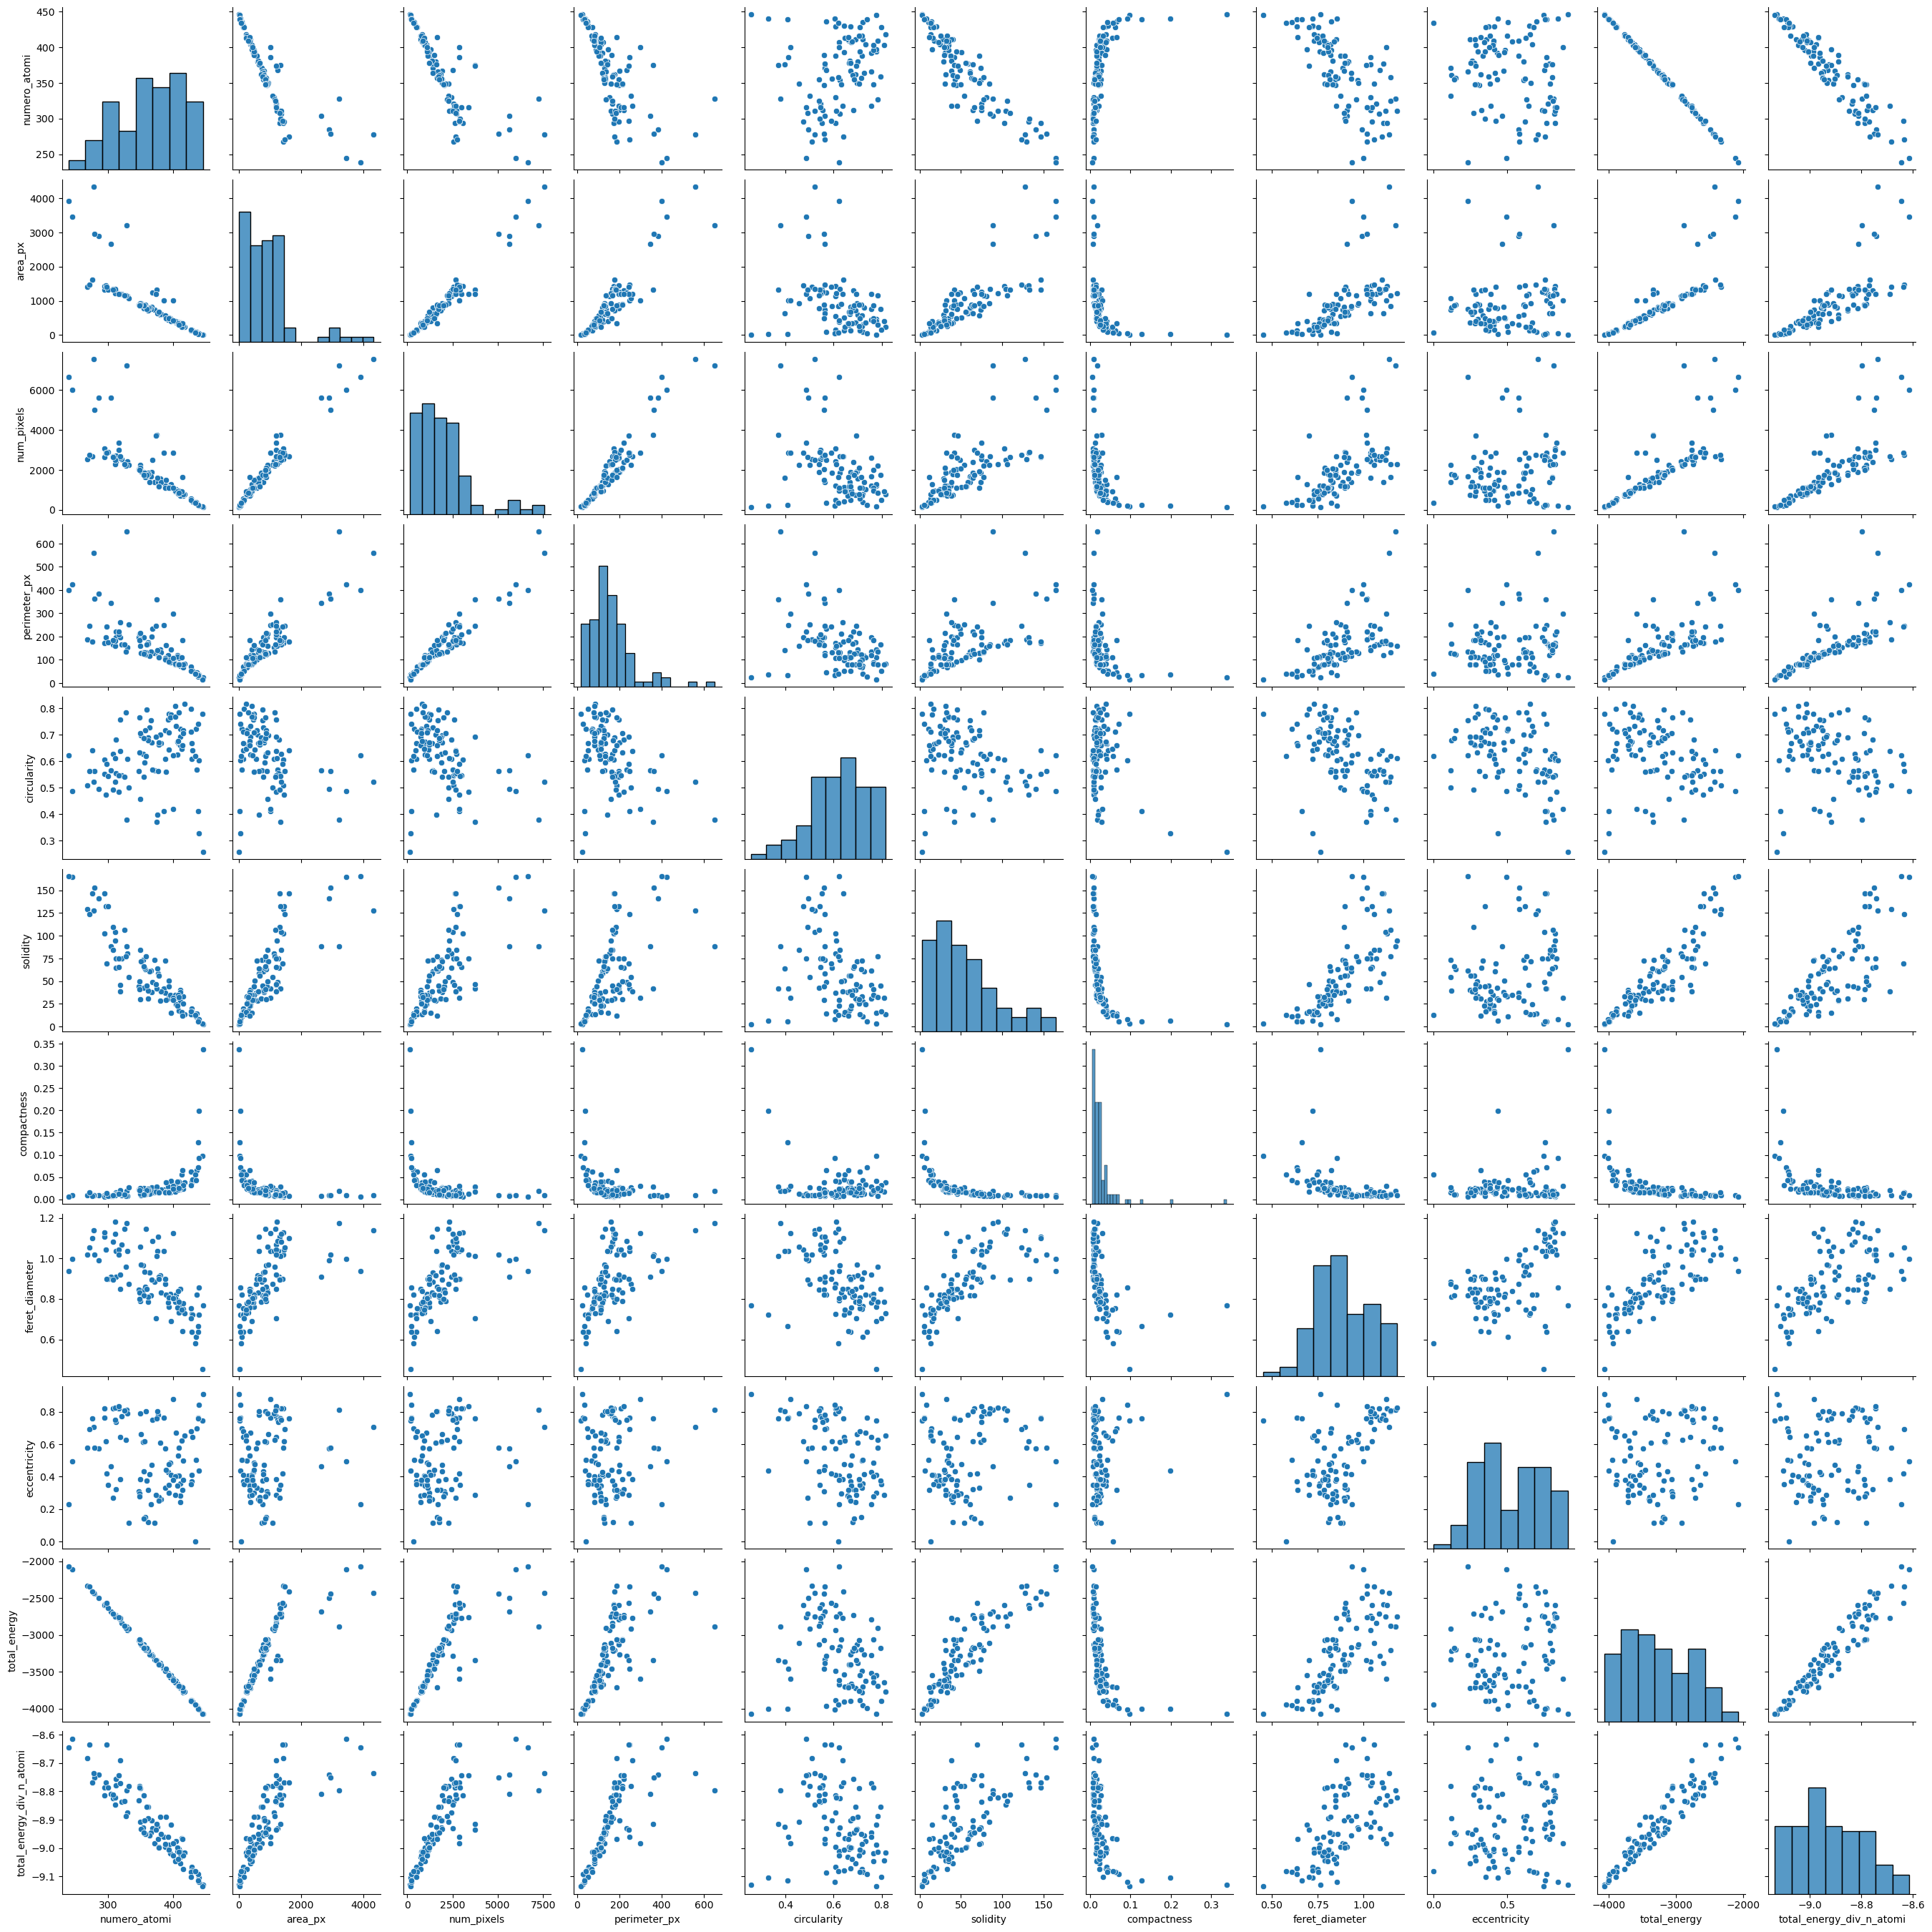

In [185]:
pathCartellaTresh = Path('/home/gabro/GrapheDetectProject/cartellaTrash')
pathCartellaContours = Path('/home/gabro/GrapheDetectProject/contours')
shapes = Features.from_thresh_to_contours_print_features(pathCartellaTresh,pathCartellaContours)
for shape in shapes:
    print("Shape features:")
    for key in shape:
        print(key, ' : ', shape[key])
    print()

boxes_df = pd.DataFrame.from_records(shapes)
boxes_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/box_dataframe.csv')
print("old df")
print(boxes_df)

# raggruppa le righe in base al nome dell'immagine e calcola la somma dell'area e del perimetro, e la media pesata per l'area degli altri parametri
grouped_df = boxes_df.groupby('nome_imm').apply(lambda x: pd.Series({
    "numero_atomi": x['numero_atomi'].max(),    #notare come i due volori del numero di atomi sono guali, scelgo il massimo solo per sceglierne uno a caso.
    'area_px': x['area_px'].sum(),  #somma semplice per area e perimetro 
    # 'area_px_div_n_atomi': x['area_px_div_n_atomi'].sum(), 
    'num_pixels': x['num_pixels'].sum(),
    'perimeter_px': x['perimeter_px'].sum(),
    # 'perimeter_px_div_n_atomi': x['perimeter_px_div_n_atomi'].sum(), 
    'circularity': (x['circularity'] * x['area_px']).sum() / x['area_px'].sum(),    #somma pesata per l'area per tutti gli altri 
    'solidity': (x['solidity'] * x['area_px']).sum() / x['area_px'].sum(),
    'compactness': (x['compactness'] * x['area_px']).sum() / x['area_px'].sum(),
    'feret_diameter': (x['feret_diameter'] * x['area_px']).sum() / x['area_px'].sum(),
    'eccentricity': (x['eccentricity'] * x['area_px']).sum() / x['area_px'].sum(),
}))
grouped_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/groupedDataframe.csv')
print("-----------------------------------------------------------------------------")
print("grouped dataframe")
# print(groupedDf)

# aggiungo total_energy facebdo il merge dal dataset dataset_graphene.csv
total_energy_dataset_df = pd.read_csv("/home/gabro/GrapheDetectProject/dataframes/dataset_graphene.csv")

merged_df = grouped_df.merge(total_energy_dataset_df[['file_name', 'total_energy']], left_on='nome_imm', right_on='file_name')
merged_df = merged_df.drop('file_name', axis=1)

merged_df = merged_df.assign(total_energy_div_n_atomi=merged_df["total_energy"] / merged_df["numero_atomi"])

# salvo e stampo il dataframe finale  
merged_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/energy_dataframe.csv')
print(merged_df)

# stampo heatmap 
corr = merged_df.corr()
sns.heatmap(corr, annot=True)

# stampo basic correlogram
sns.pairplot(merged_df)
plt.show()


## Predittore total_energy

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Prendo i dati dal dataframe Pandas e li converto nel giusto formato

In [196]:
# dataRegression = merged_df[["numero_atomi" , "area_px"]].values #una colonna per ogni feature, una riga per ogni campione 
featuresList = [ "area_px", "num_pixels", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]
dataRegression = merged_df[[ "area_px", "num_pixels", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]].values

targetRegression = merged_df["total_energy"].values.flatten() #array con tutti i valori raget total_energy
targetRegression

X = dataRegression
y = targetRegression

print(X.shape)
print(y.shape)


featuresList

(100, 7)
(100,)


['area_px',
 'num_pixels',
 'circularity',
 'solidity',
 'compactness',
 'feret_diameter',
 'eccentricity']

## Splitto il dataset e faccio tuning degli hyperparametri

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 20,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


## Scelgo il regressore e la funzione di costo

In [217]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 17025.3253


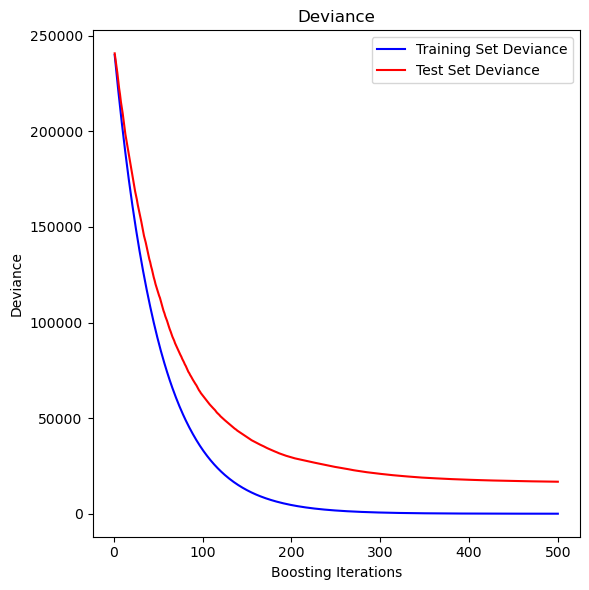

In [203]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

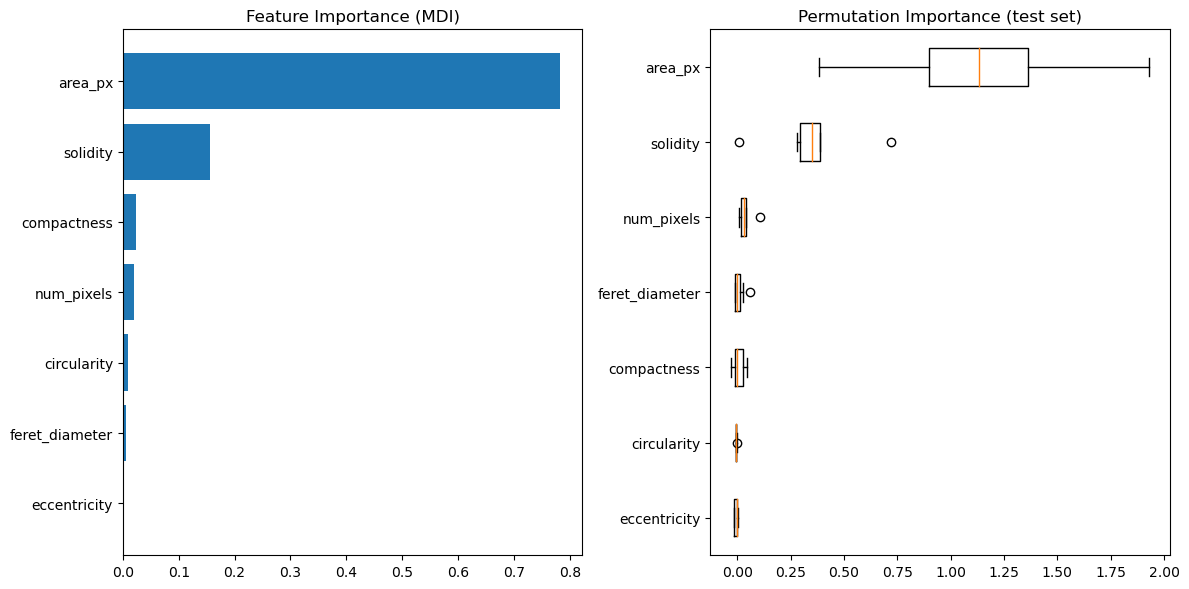

In [204]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(featuresList)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(featuresList)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()